In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import numpy as np
import cvxpy as cvx
# data for censored fitting problem.
np.random.seed(15)

n = 20;  # dimension of x's
M = 25;  # number of non-censored data points
K = 100; # total number of points
c_true = np.random.randn(n,1)
X = np.random.randn(n,K)
y = np.dot(np.transpose(X),c_true) + 0.1*(np.sqrt(n))*np.random.randn(K,1)

# Reorder measurements, then censor
sort_ind = np.argsort(y.T)
y = np.sort(y.T)
y = y.T
X = X[:, sort_ind.T]
D = (y[M-1]+y[M])/2.0

X_non_censored = X[:, 0:M, 0].T
X_censored = X[:, M:, 0].T
X_stacked = np.vstack([X_non_censored, X_censored])

y_non_censored = y[list(range(M))]
y_censored = y[list(range(M, K))]

In [3]:
A = X_stacked

c = cp.Variable((n, 1))
y_pred = cp.Variable((K, 1))

obj = cp.Minimize(cp.norm2(y_pred - A @ c)**2)
constraints = [
    y_pred[0:M, :] == y_non_censored, 
    y_pred[M:, :] >= D
]

cp.Problem(obj, constraints).solve()
c_convex = c.value

c_ls = np.linalg.inv(X_non_censored.T @ X_non_censored) @ X_non_censored.T @ y_non_censored

def calculate_error(x_true, x_est):
  return (np.linalg.norm(x_true - x_est)**2) / (np.linalg.norm(x_true)**2)

print(f"Estimated c:\n{c_convex}")
print(f"Relative error in c w.r.t least squares:{calculate_error(c_true, c_ls)}")
print(f"Relative error in c w.r.t convex opt:{calculate_error(c_true, c_convex)}")

Estimated c:
[[-0.40630978]
 [ 0.40833221]
 [-0.32259181]
 [-0.64889009]
 [ 0.34007651]
 [-1.86535867]
 [-0.91810423]
 [-1.1706461 ]
 [-0.34459277]
 [-0.46606168]
 [-0.21649437]
 [ 0.25313303]
 [ 0.52413734]
 [ 0.31509362]
 [-0.50482619]
 [ 0.58436905]
 [-0.18619959]
 [ 1.63899748]
 [ 0.68224891]
 [ 0.10731817]]
Relative error in c w.r.t least squares:0.11103680538691173
Relative error in c w.r.t convex opt:0.01706415335079822


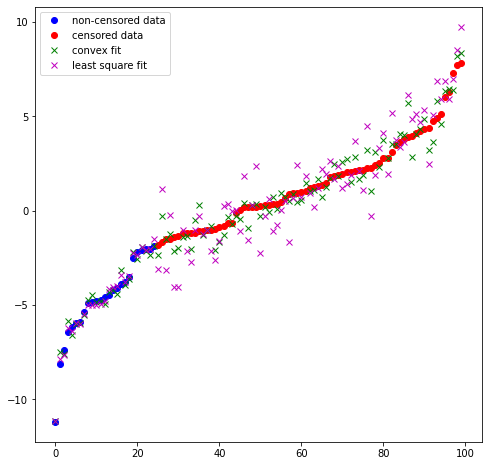

In [4]:
plt.figure(figsize=(8, 8))
plt.plot(range(0, M), y_non_censored[:, :], 'bo', label = 'non-censored data')
plt.plot(range(M, K), y_censored[:, :], 'ro', label = 'censored data')
plt.plot(range(0, K), X_stacked @ c_convex, 'gx', label='convex fit')
plt.plot(range(0, K), X_stacked @ c_ls, 'mx', label='least square fit')
plt.legend()